# Exploratory Data Analysis — PaySim Fraud Detection

I'm working with the PaySim dataset, which simulates mobile money transactions based on real transaction logs from a financial services company in Africa. The goal is to detect fraudulent transactions. Before building any models, I need to understand what the data looks like, how severe the class imbalance is, and what patterns might distinguish fraud from legitimate transactions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

df = pd.read_csv("../data/PS_20174392719_1491204439457_log.csv")
print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")

Dataset loaded: 6,362,620 rows, 11 columns


## Data Inspection

I'll start with the basics — shape, data types, a few sample rows, summary statistics, and a null check. This gives me a quick sanity check that the data loaded correctly and helps me understand what I'm working with before diving deeper.

In [2]:
print("Shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nFirst 5 rows:")
display(df.head())
print("\nSummary statistics:")
display(df.describe())
print("\nNull values per column:")
print(df.isnull().sum())

Shape: (6362620, 11)

Data types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

First 5 rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0



Summary statistics:


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00



Null values per column:


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


The dataset has 6.3 million transactions with no missing values. The columns include transaction metadata (step, type, amount), origin account info (nameOrig, oldbalanceOrg, newbalanceOrig), destination account info (nameDest, oldbalanceDest, newbalanceDest), and two target columns (isFraud, isFlaggedFraud). The `step` column represents hours from the start of the simulation, and `type` is a categorical variable with the transaction type.

## Target Variable Analysis

Now I need to look at the fraud distribution. In fraud detection, class imbalance is almost always extreme, and this dataset is no exception. Understanding the imbalance upfront is critical because it affects everything downstream — from model selection to evaluation metrics.

In [3]:
fraud_counts = df["isFraud"].value_counts()
fraud_pct = df["isFraud"].value_counts(normalize=True) * 100

print("Fraud distribution:")
print(fraud_counts)
print(f"\nFraud rate: {fraud_pct[1]:.4f}%")
print(f"Legitimate rate: {fraud_pct[0]:.4f}%")

Fraud distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraud rate: 0.1291%
Legitimate rate: 99.8709%


The fraud rate is 0.13% — only 8,213 fraudulent transactions out of 6.3 million. This means a model that predicts "not fraud" for every single transaction would achieve 99.87% accuracy. That sounds impressive until you realise it catches zero fraud.

From a business perspective, this imbalance creates an asymmetric cost problem. Missing a fraud case (false negative) means the bank or customer loses money — potentially thousands of pounds per incident. Falsely flagging a legitimate transaction (false positive) causes customer friction and support costs, but it's recoverable. The cost of missing fraud is typically much higher than the cost of a false alarm, which is why I'll focus on precision and recall rather than accuracy when evaluating models.

## Class Imbalance Visualisation

I'll create a bar chart to visualise the class imbalance. A picture is worth a thousand words when presenting to stakeholders — seeing the tiny fraud bar next to the massive legitimate bar drives the point home immediately.

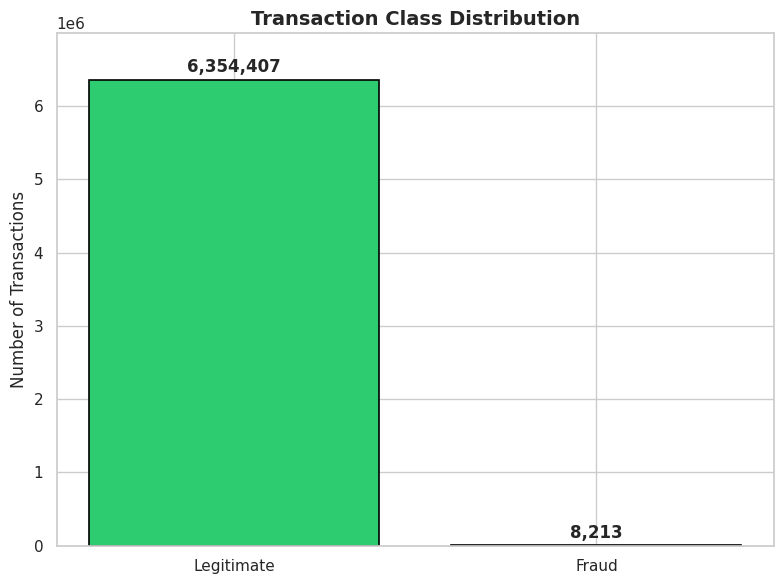

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

colours = ["#2ecc71", "#e74c3c"]  # green for legitimate, red for fraud
bars = ax.bar(["Legitimate", "Fraud"], fraud_counts.values, color=colours, edgecolor="black", linewidth=1.2)

# Add count labels on bars
for bar, count in zip(bars, fraud_counts.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50000, 
            f"{count:,}", ha="center", va="bottom", fontsize=12, fontweight="bold")

ax.set_ylabel("Number of Transactions", fontsize=12)
ax.set_title("Transaction Class Distribution", fontsize=14, fontweight="bold")
ax.set_ylim(0, fraud_counts.values[0] * 1.1)

plt.tight_layout()
plt.savefig("../images/class_imbalance.png", dpi=150, bbox_inches="tight")
plt.show()

The chart makes the imbalance visceral — the fraud bar is barely visible compared to the legitimate transactions. This visualisation will be useful in the final report to explain why standard accuracy metrics are meaningless for this problem.

## Transaction Type Analysis

Next, I want to understand which transaction types are associated with fraud. Not all transaction types are equally risky — in my experience, transfers and cash-outs tend to be the primary vectors for fraud because they move money out of the victim's control.

In [5]:
type_analysis = df.groupby("type").agg(
    total_count=("isFraud", "count"),
    fraud_count=("isFraud", "sum")
).reset_index()

type_analysis["fraud_rate"] = (type_analysis["fraud_count"] / type_analysis["total_count"]) * 100
type_analysis = type_analysis.sort_values("fraud_rate", ascending=False)

print("Fraud analysis by transaction type:")
display(type_analysis)

Fraud analysis by transaction type:


,type,total_count,fraud_count,fraud_rate
4,TRANSFER,532909,4097,0.768799
1,CASH_OUT,2237500,4116,0.183955
0,CASH_IN,1399284,0,0.000000
2,DEBIT,41432,0,0.000000
3,PAYMENT,2151495,0,0.000000


Fraud only occurs in TRANSFER and CASH_OUT transactions — zero fraud in PAYMENT, DEBIT, or CASH_IN. This makes intuitive sense from a financial services perspective. PAYMENT and DEBIT transactions typically move money to merchants or known entities, where the money can be traced and recovered. CASH_IN adds money to an account, so there's no victim.

TRANSFER and CASH_OUT, however, allow fraudsters to move stolen funds to accounts they control or withdraw cash anonymously. These are the "exit points" where fraud becomes profitable. This insight will be valuable for feature engineering — a binary flag for these high-risk transaction types could be a strong predictor.

## Amount Distribution Analysis

I want to compare transaction amounts between legitimate and fraudulent transactions. My hypothesis is that fraud amounts will have a different distribution — potentially skewing higher, since fraudsters want to maximise their take before being caught.

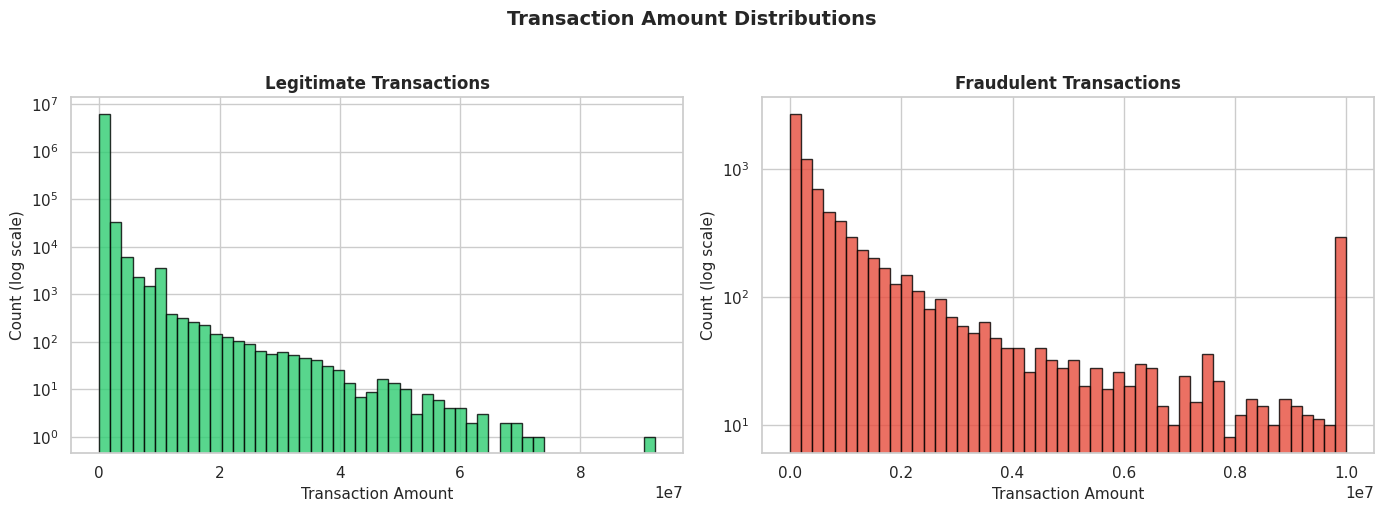

Legitimate amount — mean: 178,197.04, median: 74,684.72
Fraud amount — mean: 1,467,967.30, median: 441,423.44


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

legitimate_amounts = df[df["isFraud"] == 0]["amount"]
fraud_amounts = df[df["isFraud"] == 1]["amount"]

# Legitimate transactions
axes[0].hist(legitimate_amounts, bins=50, color="#2ecc71", edgecolor="black", alpha=0.8)
axes[0].set_yscale("log")
axes[0].set_xlabel("Transaction Amount", fontsize=11)
axes[0].set_ylabel("Count (log scale)", fontsize=11)
axes[0].set_title("Legitimate Transactions", fontsize=12, fontweight="bold")

# Fraudulent transactions
axes[1].hist(fraud_amounts, bins=50, color="#e74c3c", edgecolor="black", alpha=0.8)
axes[1].set_yscale("log")
axes[1].set_xlabel("Transaction Amount", fontsize=11)
axes[1].set_ylabel("Count (log scale)", fontsize=11)
axes[1].set_title("Fraudulent Transactions", fontsize=12, fontweight="bold")

plt.suptitle("Transaction Amount Distributions", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("../images/amount_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Legitimate amount — mean: {legitimate_amounts.mean():,.2f}, median: {legitimate_amounts.median():,.2f}")
print(f"Fraud amount — mean: {fraud_amounts.mean():,.2f}, median: {fraud_amounts.median():,.2f}")

The distributions are markedly different. Legitimate transactions are heavily concentrated in lower amounts with a long tail, while fraudulent transactions have a flatter, more spread-out distribution with higher average values. The mean fraud amount is significantly higher than the legitimate mean. This makes sense — fraudsters aren't interested in small transactions. They want to extract as much as possible before the account is frozen. The amount variable, or features derived from it (like ratio to account balance), will likely be useful predictors.

## Temporal Analysis — Fraud Rate by Hour

The `step` column represents hours from the start of the simulation. I'll extract the hour of day (step % 24) to see if fraud has any temporal patterns. Many fraud operations run during off-hours when monitoring might be lighter.

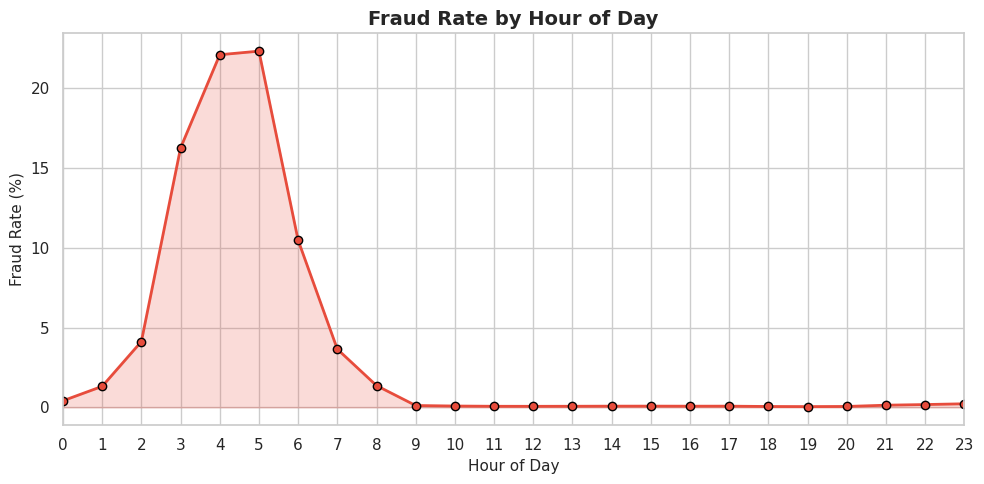

In [7]:
df["hour"] = df["step"] % 24

hourly_fraud = df.groupby("hour").agg(
    total=("isFraud", "count"),
    fraud=("isFraud", "sum")
).reset_index()
hourly_fraud["fraud_rate"] = (hourly_fraud["fraud"] / hourly_fraud["total"]) * 100

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hourly_fraud["hour"], hourly_fraud["fraud_rate"], marker="o", linewidth=2, 
        markersize=6, color="#e74c3c", markeredgecolor="black", markeredgewidth=1)
ax.fill_between(hourly_fraud["hour"], hourly_fraud["fraud_rate"], alpha=0.2, color="#e74c3c")

ax.set_xlabel("Hour of Day", fontsize=11)
ax.set_ylabel("Fraud Rate (%)", fontsize=11)
ax.set_title("Fraud Rate by Hour of Day", fontsize=14, fontweight="bold")
ax.set_xticks(range(0, 24))
ax.set_xlim(0, 23)

plt.tight_layout()
plt.savefig("../images/fraud_by_hour.png", dpi=150, bbox_inches="tight")
plt.show()

# Clean up temporary column
df.drop(columns=["hour"], inplace=True)

The fraud rate appears relatively stable across hours in this simulated dataset. There's some variation, but no dramatic spikes during specific hours that would suggest a strong temporal pattern. This is likely because PaySim is a simulation based on aggregate patterns rather than real transaction timestamps. In production systems, I'd expect to see more pronounced temporal effects. Regardless, I'll still include hour as a feature since even modest predictive power is worth capturing.

## Key Findings

- **Extreme class imbalance exists** — only 0.13% of transactions are fraudulent, meaning any model evaluation must use precision/recall/F1 rather than accuracy, and training may benefit from techniques like SMOTE or class weighting.

- **Fraud is concentrated in TRANSFER and CASH_OUT transactions** — these are the only two transaction types with any fraud, which makes sense because they're the "exit points" where money leaves the victim's control; a binary feature flagging these types should be highly predictive.

- **Fraudulent transactions have higher amounts on average** — the distribution of fraud amounts is flatter and shifted higher compared to legitimate transactions, suggesting that amount-based features (raw amount, ratio to balance) will be useful.

- **No strong hourly pattern in this simulated data** — while the fraud rate varies slightly by hour, there's no dramatic temporal signal; I'll still include hour as a feature but won't expect it to be a top predictor.

- **Balance columns may reveal anomalies** — the presence of origin/destination balance before and after transaction suggests I should engineer features that check for balance inconsistencies (e.g., did the destination balance not change despite receiving money?).

- **The dataset is clean** — no missing values and sensible data types, so I can move directly to feature engineering without data cleaning overhead.